## General Info

This notebook presents an analysis of machine learning models trained to predict
heart disease using three different data preprocessing approaches. The quality of the model was evaluated on a deferred sample.
Based on this analysis, the best-performing model and preprocessing pipeline
for the task are identified.

## Table of contents

1. [General Info](#General-Info)
2. [Dataset & Preprocessing](#Dataset-&-Preprocessing)
3. [Evaluation Metrics](#Evaluation-Metrics)
4. [Results](#Results)
   - [Imports & Settings](#Imports-&-Settings)
   - [Metrics Tables](#Metrics-Tables)
   - [Confusion Matrices](#Confusion-Matrices)
   - [Bar Plot Comparison](#Bar-Plot-Comparison)
   - [Curve Analysis](#Curve-Analysis)
     - [ROC Curve](#ROC-Curve)
     - [PR Curve](#PR-Curve)
5. [Summary](#Summary)

## Dataset & Preprocessing

The dataset was previously analyzed in the exploratory data analysis (EDA) notebook.
Three preprocessing pipelines were used in this project:

**Simple pipeline**

Contains minimal processing steps:

- Rows with missing values are removed
- Outliers are filtered using a predefined threshold
- No feature scaling
- One-Hot Encoding using Pandas

**Standard pipeline**

Includes common preprocessing steps:

- Missing values are replaced with mean (for numerical) and mode (for categorical) 
- Outliers are removed based on percentiles (IQR: 75 - 25)
- One-Hot Encoding using Scikit-Learn
- Feature scaling with StandardScaler

**Advanced pipeline**

Applies more sophisticated preprocessing:

- Categorical values are encoded by frequency
- Missing values are imputed using KNNImputer
- Feature scaling with RobustScaler
- Outliers are removed using IsolationForest

Each pipeline produces a separate train-test split and corresponding trained models.

## Evaluation Metrics

The following metrics are used to evaluate models:

- **Accuracy** - the percentage of correct predictions among all samples. It provides a general overview of model performance and is reported as a supplementary metric, as it may be misleading in medical classification tasks.

- **Precision** - the proportion of correctly identified sick patients among all patients predicted as sick by the model.  
- **Recall** - the proportion of sick patients that are correctly identified by the model, focusing on identifying as many sick patients as possible, even at the cost of increased false positives.
- **F2** - the harmonic mean of Precision and Recall. β = 2 because identifying as many sick patients as possible is more important than avoiding false alarms.
- **ROC-AUC** - the area under the Receiver Operating Characteristic curve. This metric reflects the overall discriminative ability of the model and is used as a general performance indicator.
- **PR-AUC** - the area under the Precision–Recall curve, estimated using the Average Precision (AP) score in this analysis. This metric is particularly informative for evaluating model performance on the positive (diseased) class.

These metrics provide both a **threshold-dependent evaluation** (Accuracy, Precision, Recall,  F2, Confusion Matrix) and **threshold-independent evaluation** (ROC-AUC, PR-AUC), giving a comprehensive overview of model performance.

- All metrics values can be found in the [Metrics Tables](#Metrics-Tables) section.
- Confusion Matrices are shown in [Confusion Matrices](#Confusion-Matrices).
- ROC-AUC and PR-AUC curves are visualized in [Curve Analysis](#Curve-Analysis).

## Results

#### Imports & Settings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
results_dir = Path("../results")
splits_dir = Path("../data/splits")
preprocessing_types = ['simple', 'standard', 'advanced']

#### Metrics Tables

In [4]:
simple_metrics = pd.read_csv(results_dir / 'simple_metrics.csv')
standard_metrics = pd.read_csv(results_dir / 'standard_metrics.csv')
advanced_metrics = pd.read_csv(results_dir / 'advanced_metrics.csv')

print(f'Simple: \n{simple_metrics}\n'
      f'\nStandard: \n{standard_metrics}\n'
      f'\nAdvanced: \n{advanced_metrics}\n')

Simple: 
  model  accuracy  precision    recall        f2   roc_auc
0   Ada  0.860360   0.844037  0.867925  0.863039  0.934613
1    GB  0.855856   0.836364  0.867925  0.861423  0.932254
2   KNN  0.693694   0.658333  0.745283  0.726103  0.767689
3    LR  0.869369   0.853211  0.877358  0.872420  0.931522
4    RF  0.869369   0.840708  0.896226  0.884544  0.940712
5   SVM  0.860360   0.826087  0.896226  0.881262  0.925098

Standard: 
  model  accuracy  precision    recall        f2   roc_auc
0   Ada     0.848   0.860294  0.860294  0.860294  0.916925
1    GB     0.840   0.842857  0.867647  0.862573  0.923375
2   KNN     0.848   0.845070  0.882353  0.874636  0.906540
3    LR     0.860   0.874074  0.867647  0.868925  0.914280
4    RF     0.832   0.830986  0.867647  0.860058  0.913087
5   SVM     0.828   0.839416  0.845588  0.844347  0.908540

Advanced: 
  model  accuracy  precision    recall        f2   roc_auc
0   Ada  0.846743   0.871429  0.847222  0.851955  0.920406
1    GB  0.858238   0.8

The key metrics are Recall, Precision, and F2, as they indicate how many patients the model correctly identifies and how accurate these predictions are.

* The highest Recall and F2 were achieved with the advanced pipeline using  Gradient boosting (Recall ≈ 0.91, F2 ≈ 0.90).

* The lowest performance was observed with the simple pipeline using KNN (Recall ≈ 0.74, F2 ≈ 0.73).

#### Confusion Matrices

<Figure size 800x600 with 0 Axes>

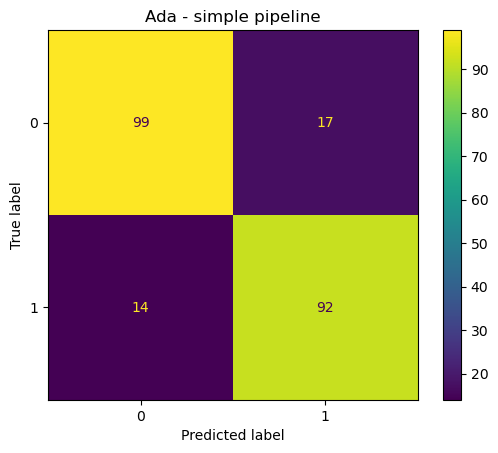

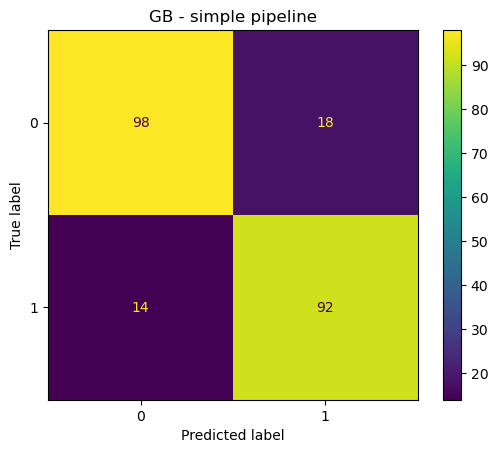

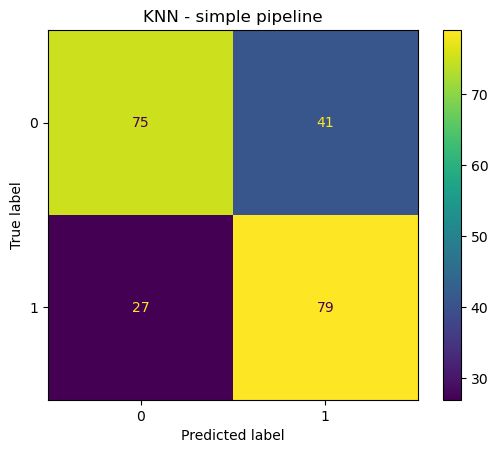

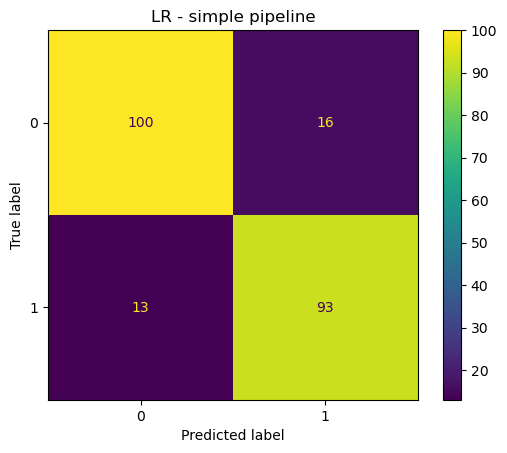

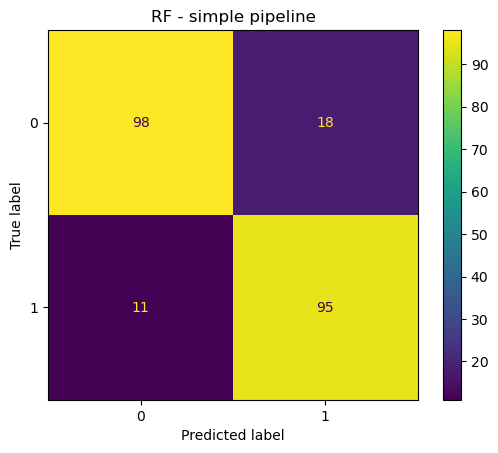

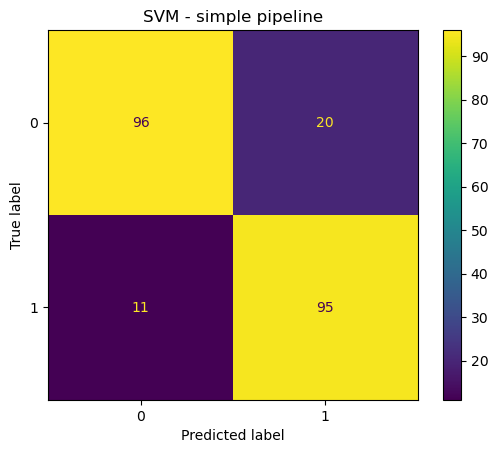

<Figure size 800x600 with 0 Axes>

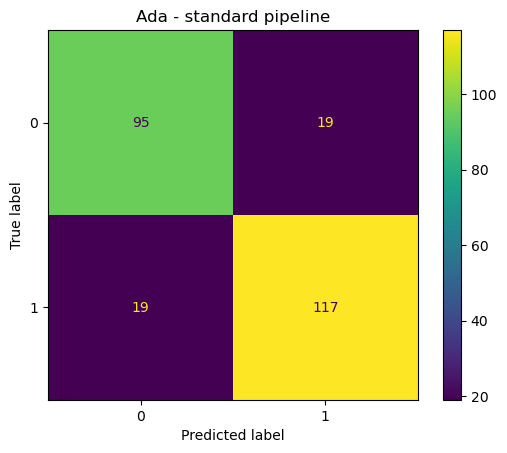

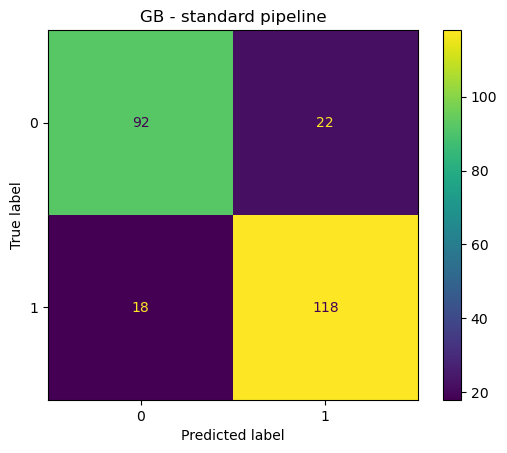

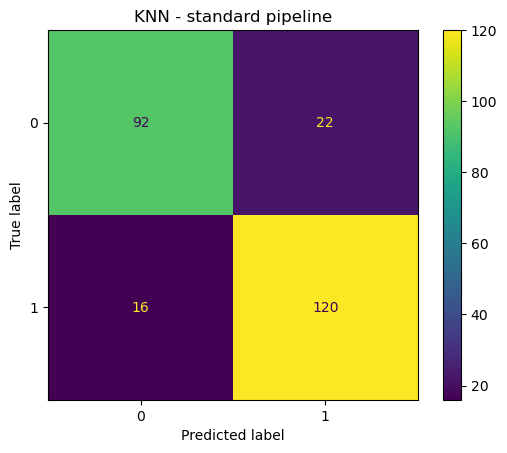

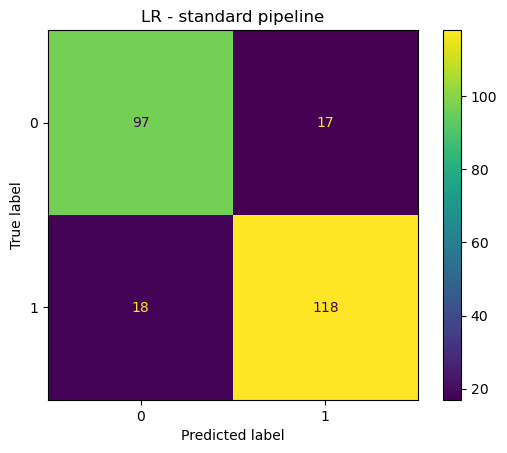

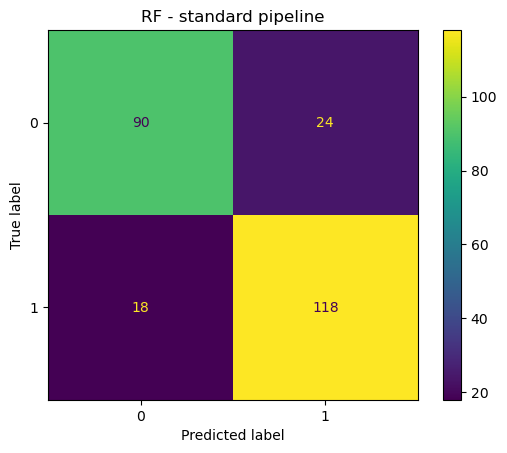

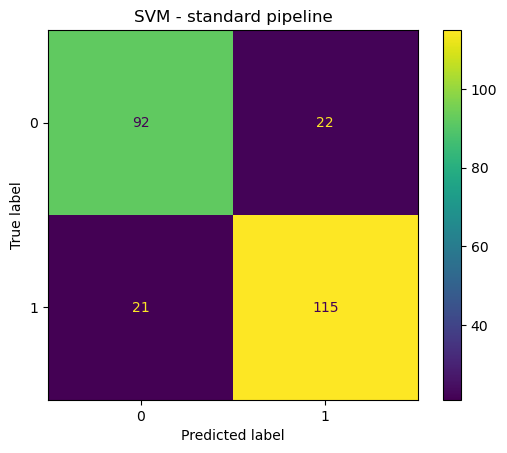

<Figure size 800x600 with 0 Axes>

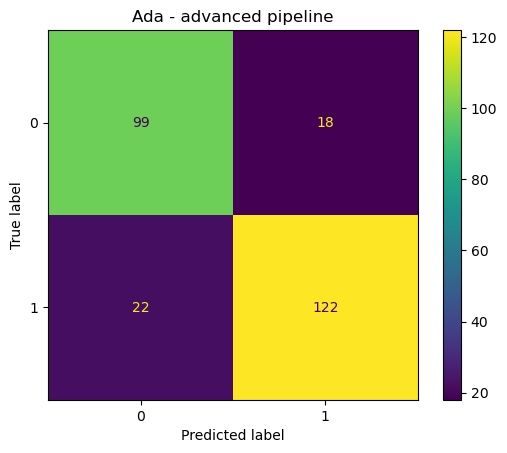

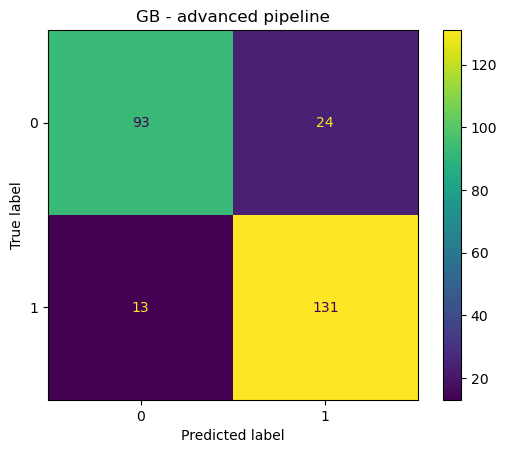

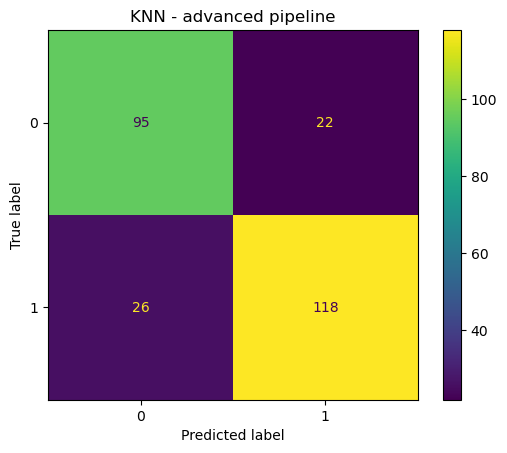

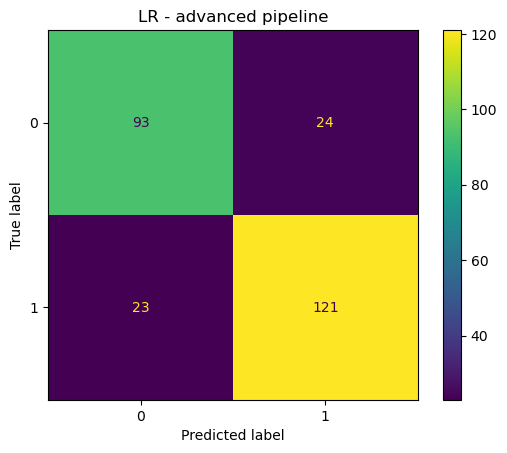

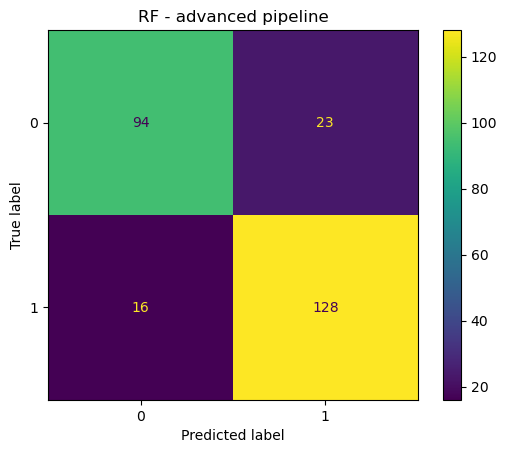

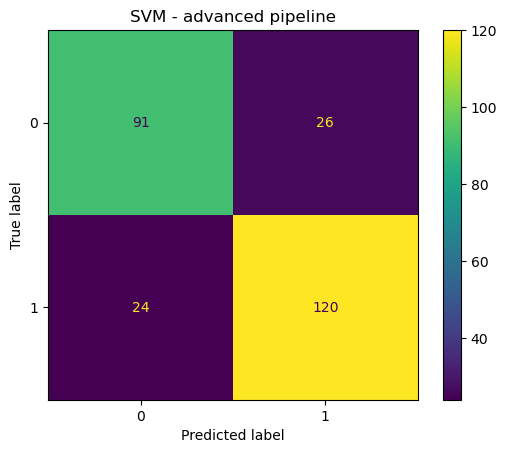

In [10]:
for prep in preprocessing_types:
    predict_file = Path(results_dir / f'{prep}_y_predict.npy')
    y_predictions = np.load(predict_file, allow_pickle=True).item() 
    y_test = pd.read_csv(splits_dir / f'{prep}_y_test.csv').values.ravel()

    plt.figure(figsize=(8,6))
    
    for model_name, y_pred in y_predictions.items():
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
        disp.plot()
        plt.title(f"{model_name} - {prep} pipeline")
        plt.show()

In the task of detecting heart disease, missing a sick patient (False Negative) is a more critical error than falsely identifying a healthy person as sick (False Positive).

According to the confusion matrices, the worst-performing pipeline was KNN with simple preprocessing: the model missed nearly 25% of sick patients and incorrectly classified about 35% of healthy individuals as sick.

The lowest False Negative rate was achieved by Gradient Boosting (FN ≈ 9%), but its False Positive rate was relatively high (≈ 20%).
Random Forest with simple preprocessing showed a slightly higher FN rate (≈ 10%) but a lower FP rate (≈ 15%).

Although Gradient Boosting achieved the lowest FN rate, Random Forest with simple preprocessing provides a better trade-off between FN and FP, making it the most suitable model for this task.

#### Bar Plot Comparison

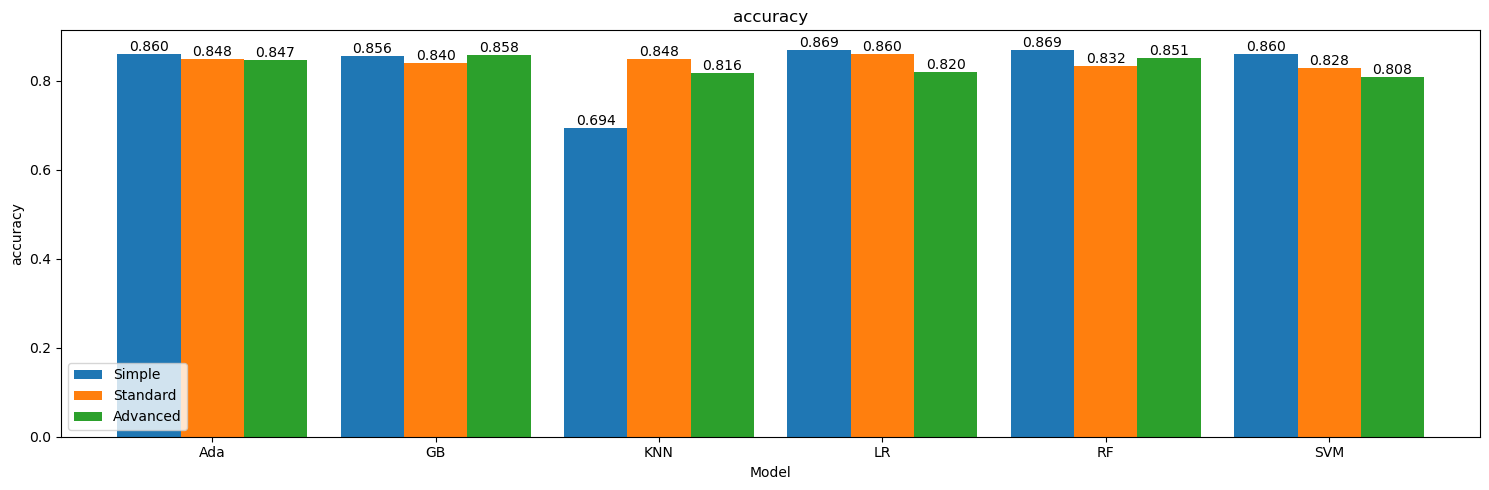

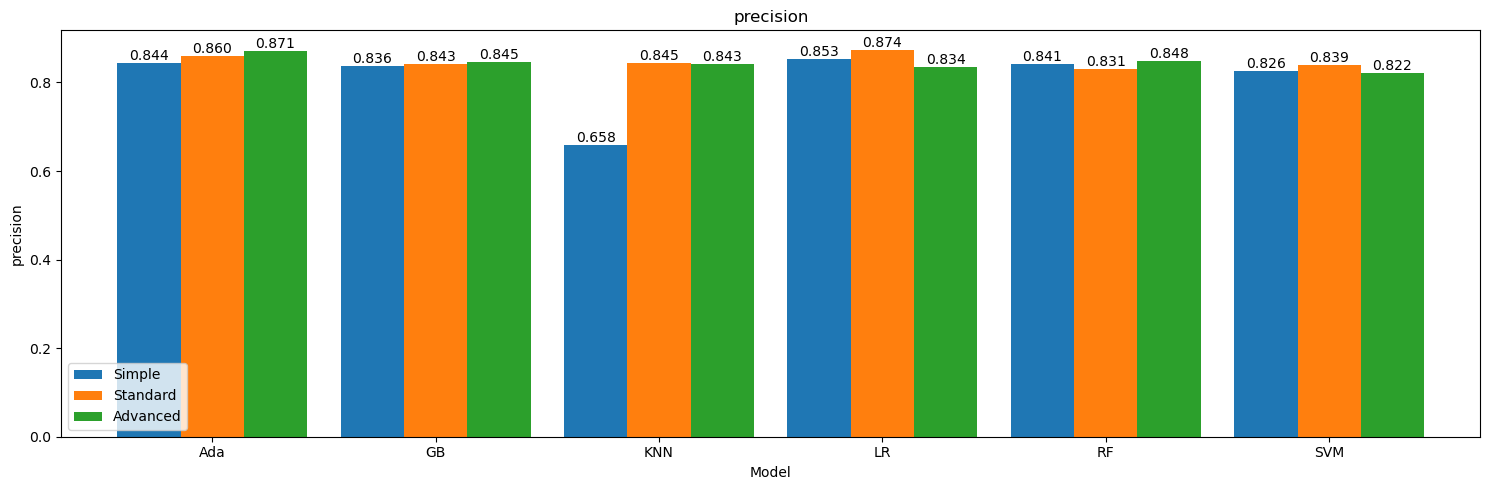

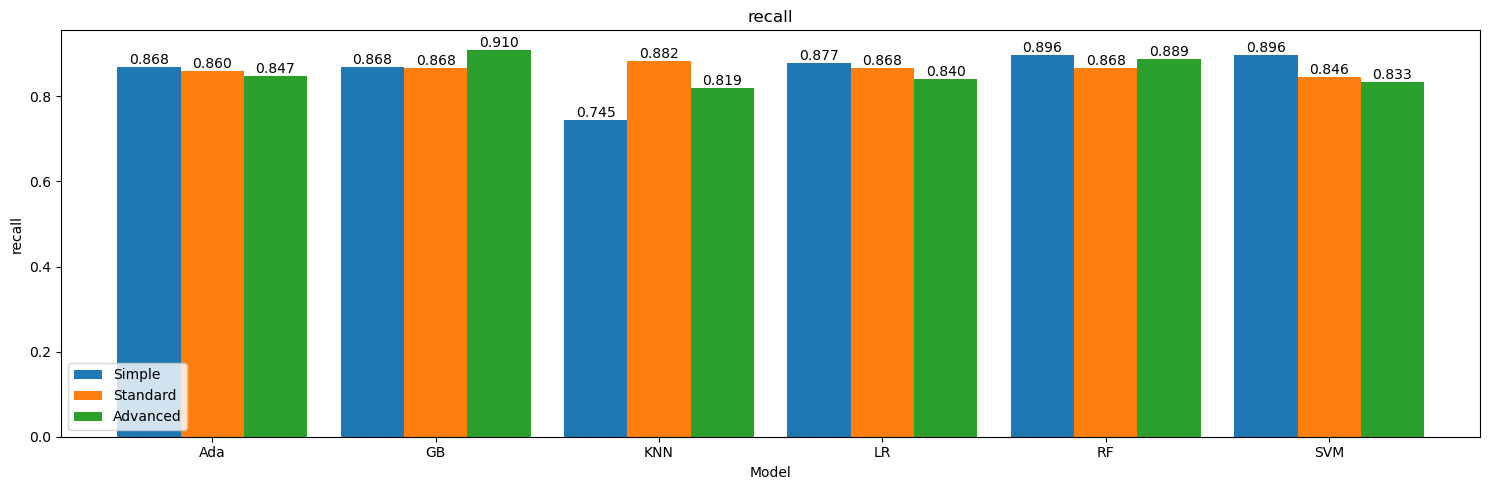

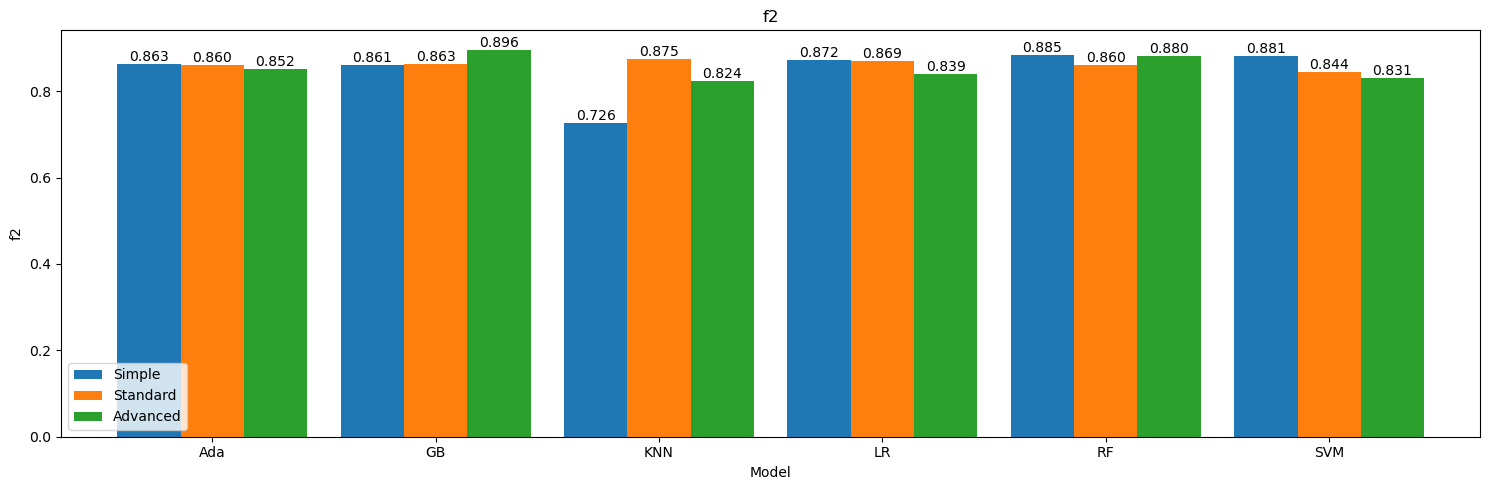

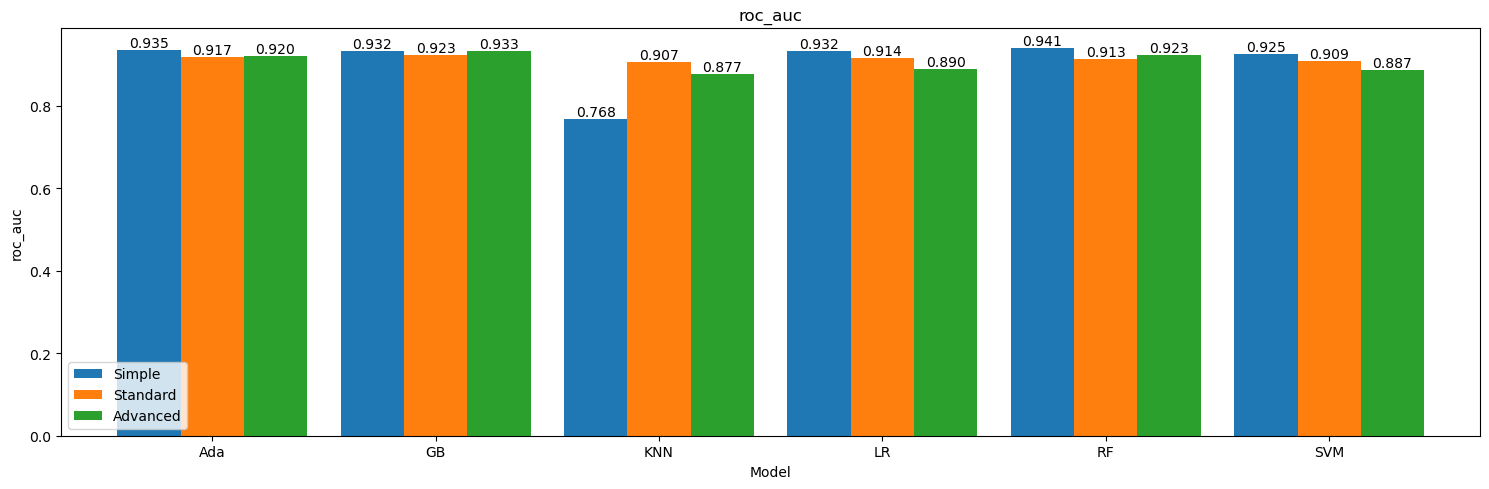

In [5]:
metrics = simple_metrics.columns.drop('model')

for metric in metrics:
    comparison = pd.DataFrame({
        'Model': simple_metrics['model'],
        'Simple': simple_metrics[metric],
        'Standard': standard_metrics[metric],
        'Advanced': advanced_metrics[metric]
    })
    comparison.set_index('Model', inplace=True)
    
    ax = comparison.plot(
        kind='bar',
        figsize=(15, 5),
        title=metric,
        width=0.85
    )
    ax.set_ylabel(metric)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

The bar charts confirm the conclusions drawn from the tables.
The highest Recall and F2 values were achieved by the GradientBoosting model with advanced preprocessing (Recall ≈ 0.91, F2 ≈ 0.90).
The lowest performance was observed in the KNN model with simple preprocessing (Recall ≈ 0.74, F2 ≈ 0.73).

#### Curve Analysis

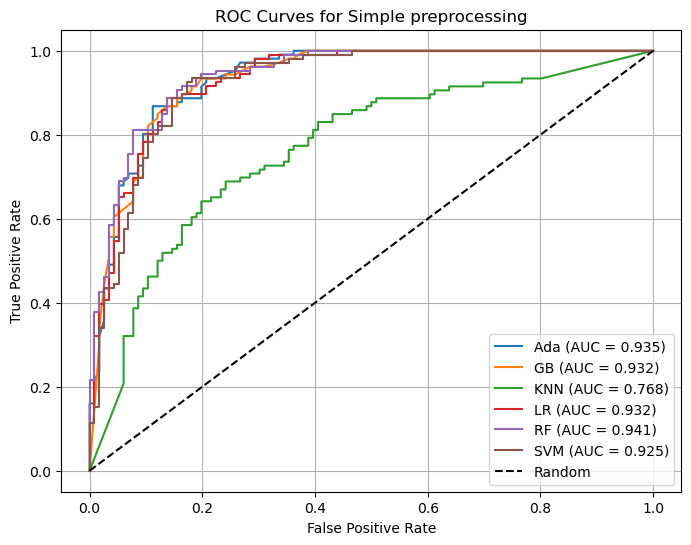

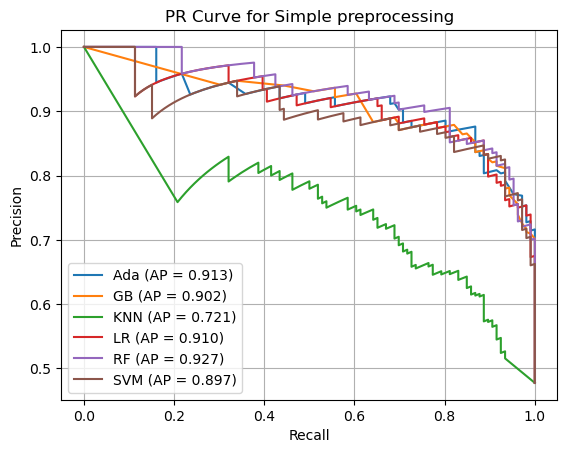

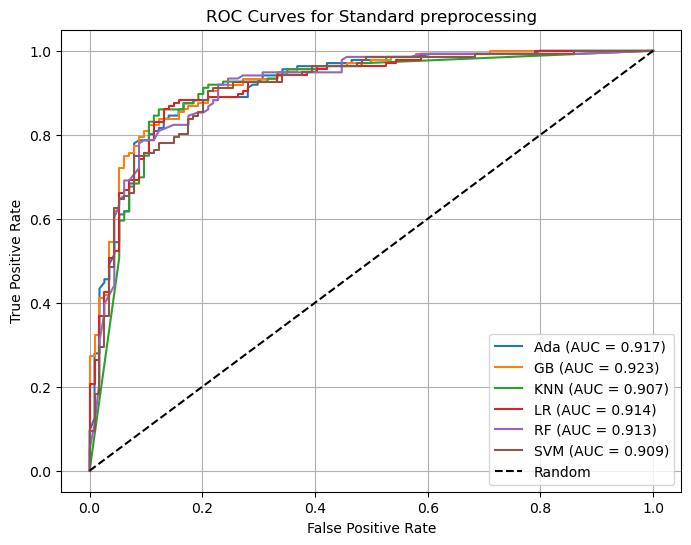

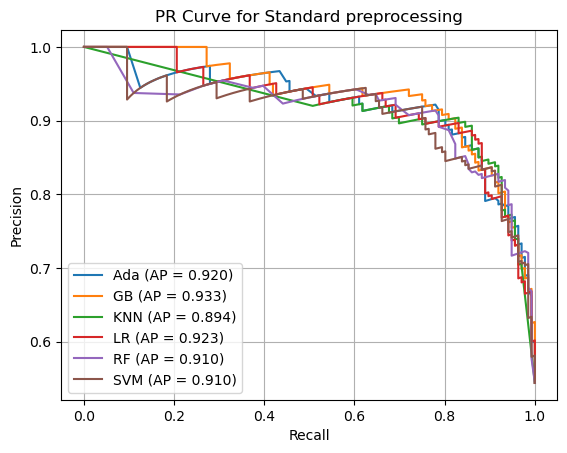

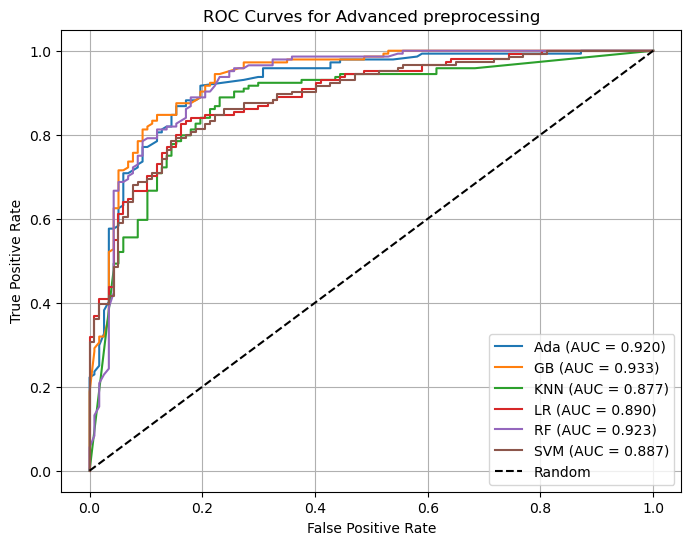

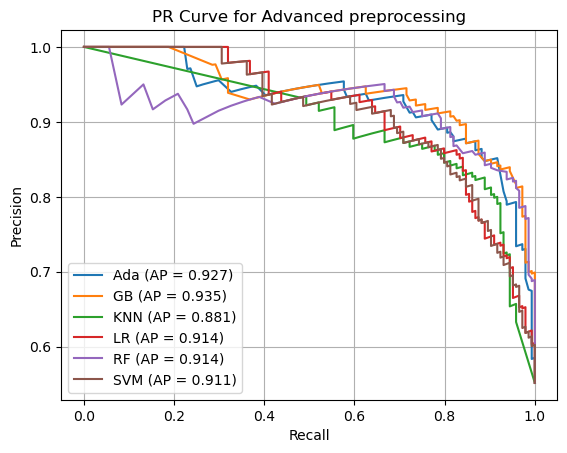

In [11]:
for prep in preprocessing_types:
    score_file = Path(results_dir / f'{prep}_y_scores.npy')
    metrics = Path(results_dir / f'{prep}_metrics.csv')
    df_metrics = pd.read_csv(metrics)

    y_scores = np.load(score_file, allow_pickle=True).item()
    y_test = pd.read_csv(splits_dir / f'{prep}_y_test.csv').values.ravel()

    plt.figure(figsize=(8,6))

    for model_name, y_score in y_scores.items():
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = df_metrics.loc[df_metrics['model'] == model_name, 'roc_auc'].values[0]
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

    plt.plot([0,1], [0,1], 'k--', label="Random")

    plt.title(f"ROC Curves for {prep.capitalize()} preprocessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    for model_name, y_score in y_scores.items():
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, label=f"{model_name} (AP = {ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve for {prep.capitalize()} preprocessing")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

##### ROC Curve

**Simple preprocessing:**

With simple preprocessing, almost all models except KNN achieve a TPR close to 1 at relatively low FPR values. AdaBoost, Gradient Boosting, and Random Forest reach high true positive rates earlier than the other models. The KNN model performs significantly worse than the others, with the lowest AUC (0.768), lower TPR, and higher FPR across most thresholds, making it the weakest option in this preprocessing setup.

**Standard preprocessing:**

Under standard preprocessing, the performance of all models becomes more similar. ROC curves are closely aligned, and all models achieve high TPR values, although at higher FPR levels compared to simple preprocessing. The differences between AdaBoost, Random Forest, Gradient Boosting, Logistic Regression, and SVM are marginal, indicating that standard preprocessing reduces performance gaps between models.

**Advanced preprocessing:**

With advanced preprocessing, Gradient Boosting demonstrates the best performance, achieving a high TPR at lower FPR values and the highest AUC among the evaluated models. AdaBoost and Random Forest show comparable results, with only minor differences

Overall, simple preprocessing allows most models to achieve high true positive rates at relatively low false positive rates, while KNN performs poorly in this setup. Standard preprocessing reduces performance differences between models, leading to similar ROC behavior but at the cost of higher false positive rates. Advanced preprocessing provides the best overall discrimination, with Gradient Boosting achieving the most favorable trade-off between TPR and FPR and the highest AUC among the evaluated models.

##### PR Curve

Since recall is a priority for the task, particular attention is paid to the behavior of precision at high recall values. The analysis of the precision–recall curves shows that Gradient Boosting achieves the highest Average Precision under standard and advanced preprocessing, while Random Forest performs best with simple preprocessing.

**Simple preprocessing:**

With simple preprocessing, KNN performs significantly worse than the other models, rapidly losing precision. In contrast, AdaBoost, Gradient Boosting, and Random Forest maintain relatively high precision (around 0.7) even at recall values close to 1.

**Standard preprocessing:**

Under standard preprocessing, the differences between models become less pronounced. However, all models exhibit lower precision at high recall values (approximately 0.6) compared to the other pipelines.

**Advanced preprocessing:**

With advanced preprocessing, Gradient Boosting demonstrates the most favorable precision–recall behavior, achieving high recall while maintaining comparatively high precision, which is further supported by the highest Average Precision value.

Thus, considering both the shape of the precision–recall curves and the Average Precision values, Gradient Boosting combined with advanced preprocessing represents the most preferable model for this task, which is consistent with the conclusions drawn from the ROC curve analysis.

## Summary

Based on the comprehensive analysis, the pipeline combining Gradient Boosting with advanced preprocessing emerged as the most effective, whereas KNN with simple preprocessing performed the worst. These outcomes can be explained by several key factors:
1. **Nonlinear dependencies in the data** - EDA revealed nonlinear relationships that distance-based models struggle to capture effectively.
   
2. **Sensitivity of KNN to feature scaling** - KNN performance heavily depends on proper feature scaling, which is absent in the simple preprocessing pipeline. In contrast, models like Logistic Regression and SVM are more robust to unscaled features.

   
3. **Sequential learning advantage of Gradient Boosting** - Gradient Boosting iteratively builds models where each subsequent model focuses on correcting the errors of the previous ones, leading to superior predictive performance.

4. **RobustScaler in advanced preprocessing** -  The advanced preprocessing pipeline applies RobustScaler, which is based on median and IQR, making it less sensitive to critical points, which there are many in the data, but they are not outliers. Additionally, it retains a larger portion of the data after preprocessing steps.

5. **Limitations of standard preprocessing** - While standard preprocessing improves data versatility and reduces discrepancies between models, it generally yields lower performance compared to advanced preprocessing.

Thus, the best pipeline on the test set turned out to be Gradient Boosig + advanced preprocessing.